In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
path = '/Users/ctlewis/Documents/Programs_Coding/Ackersonetal_2018_fig2data.xlsx'
sheet = 'Sheet1'

# import dataset
data = pd.read_excel(path,
                     sheet_name=sheet)
data.head()
data = data.groupby('sample')

In [74]:
kcp = data.get_group('kcp')
kcp = kcp[kcp['dist'] <= 1180]
kcp = kcp.reset_index()

kga = data.get_group('kga')
kga = kga.reset_index()

<ErrorbarContainer object of 3 artists>

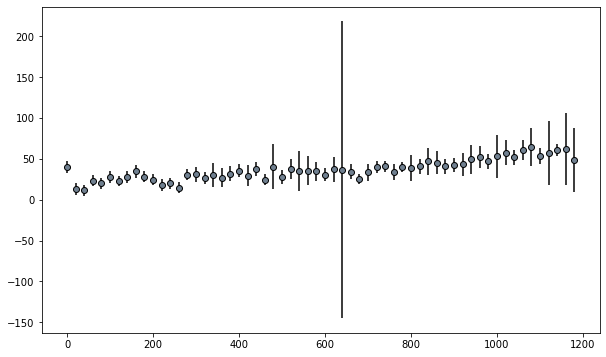

In [77]:
# turn the data of interest into a 1D array
Ti = kcp.ti # Fig 2.C data. Low Ti on rim side
Ti = np.flip(Ti)

# set the resolution of your data (distance between spots) 
resolution = 20 # um
L = np.linspace(0,(len(Ti)-1)*resolution,len(Ti)) # an array containing x data from start to finish
                                                  # This is used for setting up your mesh later
# L = np.flip(L)
    

#plot measured profile
fig,ax = plt.subplots(figsize=(10,6))
ax.errorbar(L,Ti,yerr=kcp.ti_err,fmt='o',mfc='slategray',mec='k',ecolor='k')
# ax.plot(L,Ti,'ok')

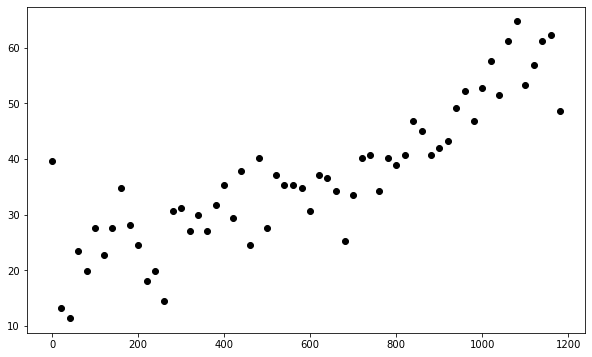

In [78]:
#plot measured profile
fig,ax = plt.subplots(figsize=(10,6))
# ax.errorbar(L,Ti,yerr=kcp.ti_err,fmt='o',mfc='slategray',mec='k',ecolor='k')
ax.plot(L,Ti,'ok')

In [89]:
# spots from the interior point to where you want your initial step function to be (python starts counting at 0)
xth_spot = len(L) - 26 # count from opposite side since it is less poinnts to count
x_core = L[xth_spot] # core side
dx = resolution
x_core_mesh = int(x_core/dx) # the ith point in your x-value mesh that will diffuse

C_core = Ti[xth_spot] # core side concentration
C_rim = Ti[xth_spot-1] # rim side concentration

#initial condition
u_n = np.zeros(len(L)) # Creates an array of appropriate size to set your initial condition for concentration
                        # This is u at the t-1 (i.e., previous) time. Also used to set initial condition
u_n[x_core_mesh:] = 58 # Set a constant concentration on the core side of the crystal - flip colon if rim on other side
u_n[:x_core_mesh] = 25 # Set a constant concentration on the rim side of the crystal - flip colon if rim on other side
# note hte colons would need to be flipped in the diffusion function below as well

print(len(L)-26)

34


(8.0, 70.0)

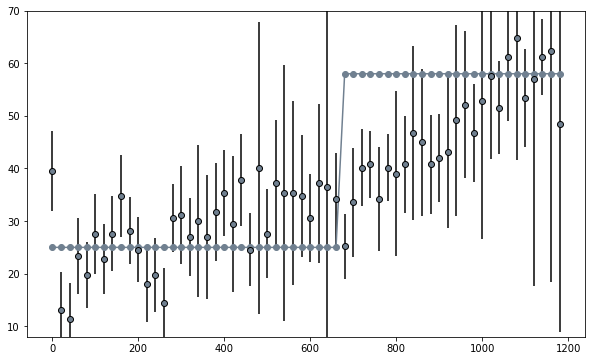

In [90]:
# plot your data and the initial profile
fig,ax = plt.subplots(figsize=(10,6))
ax.errorbar(L,Ti,yerr=kcp.ti_err,fmt='o',mfc='slategray',mec='k',ecolor='k')
ax.plot(L,u_n,'-',marker='o',color='slategray')
ax.set_ylim(8,70)

In [91]:
# set up your time mesh that you will use to run the diffusion model
def time_mesh(maxtime,iterations,timeunit='years'):
    """
    Create a time mesh for your model.
    Function converts your chosen unit into seconds in order to keep units consistent in
    the function below.
    
    Inputs:
    maxtime: The maximum amount of time you want the model to run
    iterations: How many steps you want between the start time and Maxtime.
    timeunit: The unit you used in the inputs above
    
    Returns
    t: a 1D array that has your maxtime split by n+1 interations
    """
    if timeunit == 'years':
        step = 60 * 60 * 24 * 365.25
    elif timeunit == 'months':
        step = (60 * 60 * 24 * 365.25)/12
    elif timeunit == 'days':
        step = 60 * 60 * 24
    elif timeunit == 'hours':
        step = (60 * 60 * 24 * 365.25)/8760
    elif timeunit == 'seconds':
        step = (60 * 60 * 24 * 365.25)/3.154e7
    
    t = np.linspace(0,maxtime*step,int(iterations+1))
    return t

In [110]:
t = time_mesh(100000000,4000,'years')
len(t)

4001

In [111]:
def Tiinqtz_diffusion_1D(Ti,resolution,xth_spot,t,T,D='default',C_core='default',C_rim='default'):
    """
    Run a 1D Ti in quartz diffusion model based on a forward Euler scheme with a boundary condition determined by the user.
    In the simplest since, the model solves u for matrices of type A * u = b, 
    where u is unknown, A is a matrix of mesh points in the x (nx) and time (nt) dimensions, 
    and b is vector of knowns that gets updated as time moves forward.
    
    The forward Euler scheme is the forward finite difference scheme of Fick's second law:
    
    d/dt C(x,t) = D d/dx^2 C(x,t)
    
    where t is time, x is distance, D is the diffusion coefficient, and C(x,t) is the concentration as a function
    of distance and time. If you wish to have an open boundary with the diffiusion coefficient dependent on the
    concentration, this goes as:
    
    d/dt C(x,t) = d/dx D d/dx C(x,t) + D d/dx^2 C(x,t)
    
    Inputs:
    Ti: Slice of a Pandas dataframe or python list containing your Qtz data
    Resolution: Distance between measurements on your crystal (µm)
    xth_spot: The spot from the interior (core) point where you want the step function to be located. Note python
              starts counting at zero.
    t: A 1d array that is output from the time_mesh function above
    T: Temperature (K)
    D: Method to calculate diffusion coefficient from published literature. Defaults to Audetat et al. (2021). Other
    input options include 'J' for Jollands et al. (2020) and 'C' for Cherniak et al. (2007).
    u_n: Initial data profile output from the function above
    C_core: Boundary condition for the concentration at the core side of your crystal. If you input a value, this is
            the boundary condition for recalculating Di at each timestep. The default is the Fo concentration at the
            x_thspot you input above
    C_rim: Similar to C_core but for the next distance step forward.
    
    Returns:
    F: The mesh Fourier number. This is a measure of your numerical stability. You will get an error warning you if
       the numerical model is unstable.
    solutions: A set of numpy arrays containing the concentration solution for each timestep
    Di_arrays: A set of numpy arrays containing the solutions to the Di at each timestep
    """
    Ti = Ti.to_numpy() # Ti content for olivine

    L = np.linspace(0,(len(Ti)-1)*resolution,len(Ti))
    nx = len(L)
    dx = L[1] - L[0]
    x_core = L[xth_spot]
    x_core_mesh = int(x_core/dx)
    
    dt = t[1] - t[0]
    iterations = len(t)-1
    nt = len(t)
    
    solutions = np.zeros((nt,nx))
    u = np.zeros(len(L))
    
    if C_core == 'default':
        C_core = Ti[xth_spot-1]
    elif C_core > 0:
        Ti[-1] = C_core # change to Ti[0] if rim on other side
    if C_rim == 'default':
        C_rim = Ti[xth_spot]
    elif C_rim > 0:
        Ti[0] = C_rim # change to Ti[-1] if rim on other side
        
    u_n = np.zeros(len(L))
    u_n[x_core_mesh:] = C_core
    u_n[:x_core_mesh] = C_rim
    
    if D == 'default':
        Di = (10**(-11.31-((262.0*1000)/(2.303*8.3144*T))))*10e12
    elif D == 'J':
        Di = (10**(-8.3-((311.0*1000)/(2.303*8.3144*T))))*10e12
    elif D == 'C':
        Di = (7e-8*np.exp((-273.0*1000)/(8.3144*T)))*10e12
    else:
        print('There is something wrong with the input value for D')
        
    for i in range(0,int(nt)):
        import time; t0 = time.perf_counter()
        u[1:nx-1] = u_n[1:nx-1] + ((Di)*(u_n[2:nx]-u_n[1:nx-1])+(Di)*(u_n[2:nx]-2*u_n[1:nx-1]+u_n[0:nx-2]))*(dt/(dx**2))
        u[-1] = C_core; u[0] = C_rim # flip the 0 and -1 if rim on other side
        solutions[i,:] = u
        u_n[:] = u
        t1 = time.perf_counter()

    F = Di*dt/dx**2
    if F > 0.5:
        print('Mesh Fourier Number is too high causing instability in the model. Decrease dt')

    return solutions, F,Di

In [112]:
T = 775.0+273 # Temperature (K)

# def Tiinqtz_diffusion_1D(Ti,resolution,xth_spot,t,T,D='default',C_core='default',C_rim='default'):
#%timeit solutions, F, D = Tiinqtz_diffusion_1D(Ti,6,12,t,T,D='C',C_core=55,C_rim=25)
solutions, F, D = Tiinqtz_diffusion_1D(Ti,20,34,t,T,D='default',C_core=58,C_rim=25)

In [113]:
def least_squaredresiduals(solutions,Ti):
    """
    Function for finding the best fit by least squared residuals
    ---
    Inputs:
    solutions: numpy array output from the diffusion model
    Fo: your data. Same input as that you used for the diffusion model
    """
    
    from scipy.signal import argrelextrema # import package to find local minima / maxima
    
    L = np.linspace(0,(len(Ti)-1)*resolution,len(Ti)) # make an array
    nx = len(L) # set the length over which you will calculate the least squares
    
    least_residuals_fit = np.zeros_like(solutions) # make an array of zeros to be filled by the function below
    
    # make a loop to calculate the least squares. this iterates through all sets of solutions (i) that were calculated
    # at time t_i along the length of your diffusion profile (nx, above; defined as the kth spot below)
    for i in range(0,len(solutions)):
        for k in range(0,int(nx)):
            least_residuals_fit[i,k] = (solutions[i,k]-Ti[k])**2 / Ti[k]
    
    summed_residuals = np.sum(least_residuals_fit,axis=1) # sum calculated squared residuals along the length of solutions
    min_residuals = np.min(summed_residuals) # find the solution with the minimum residual
    locbestfit = np.argwhere(summed_residuals == min_residuals).item() # locate which solution that is
    bestfit_solution = solutions[locbestfit] # set that solution as the 'best fit solution'
    
    # Flag your solution sets to see if there are local minima. May need to make a judgement call if so
    localminima = summed_residuals[argrelextrema(summed_residuals, np.less)[0]]
    if len(localminima) > 1:
        print('You have more than one minima. You need to manually check all local minima to determine best fit')
    
    return min_residuals, bestfit_solution, locbestfit, summed_residuals, localminima

In [114]:
#%timeit min_residuals, bestfit_solution, locbestfit, summed_residuals, localminima = least_squaredresiduals(solutions,Fo)
min_residuals, bestfit_solution, locbestfit, summed_residuals, localminima = least_squaredresiduals(solutions,Ti)
t[locbestfit]

135697680000000.0

Text(0.5, 1.0, 'C1-L1, Audetat D, 775°C')

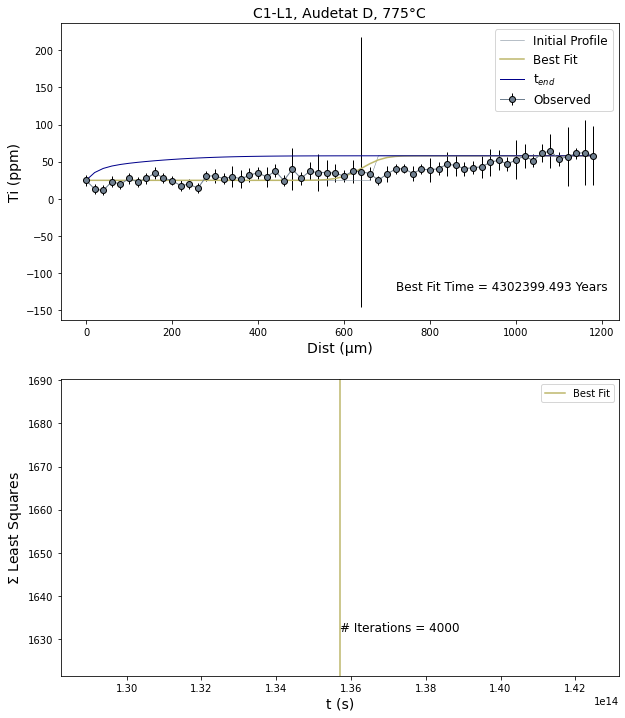

In [115]:
fig, ax = plt.subplots(2,1, figsize=(10,12))

ax[0].plot(L,u_n,'-',color='slategray',lw=0.5,label='Initial Profile')
linestyle = {"linestyle":"-", "linewidth":1, "color":'slategray'}
ax[0].errorbar(L,Ti,yerr=kcp.ti_err,fmt='o',mfc='slategray',mec='k',ecolor='k',**linestyle,label='Observed')
ax[0].plot(L,solutions[locbestfit,:],'-',color='darkkhaki',lw=1.5,label='Best Fit')
ax[0].plot(L,solutions[-1,:],'-',color='darkblue',lw=1,label='t$_{end}$')
ax[0].text(0.6,0.1,'Best Fit Time = ' + str(round(t[locbestfit]/3.154e7,3)) + ' Years',transform=ax[0].transAxes,fontsize=12)

ax[0].set_xlabel('Dist (µm)',fontsize=14)
ax[0].set_ylabel('Ti (ppm)',fontsize=14)
ax[0].legend(loc='best',fontsize=12)


# for i in range(0,len(summed_residuals)):
#     ax[1].plot(t,summed_residuals,color='slategray')
ax[1].plot([t[locbestfit],t[locbestfit]],[0,max(summed_residuals)+10],'-',label='Best Fit',color='darkkhaki')

ax[1].set_ylim(min(summed_residuals)-2,max(summed_residuals)+2)
ax[1].set_xlabel('t (s)',fontsize=14)
ax[1].set_ylabel('$\Sigma$ Least Squares',fontsize=14)
ax[1].legend(loc='best')
ax[1].text(0.5,0.15,'# Iterations = 4000',transform=ax[1].transAxes,fontsize=12)

ax[0].set_title('C1-L1, Audetat D, 775°C',fontsize=14)

# plt.savefig('C1-L1, Audetat D, 819',format='pdf',dpi=250)